In [1]:
dataset_base_path = r'/Users/kripik123/Documents/dataset/processedx/'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
##import shap
import scikitplot as skplt
##import eli5
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
##from sklearn.dummy import DummyClassifier
##from sklearn.linear_model import LogisticRegression
##from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
##from catboost import CatBoostClassifier
##from catboost import Pool
##from eli5.sklearn import PermutationImportance
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict
from scipy.stats import ks_2samp
from scipy.stats import describe
##from imblearn.over_sampling import SMOTENC
from collections import Counter
from IPython.display import display

%matplotlib inline

In [2]:
types = {
    'dst_port': 'uint32',
    'protocol': 'uint8',
    'timestamp': 'object',
    'flow_duration': 'int64',
    'tot_fwd_pkts': 'uint32',
    'tot_bwd_pkts': 'uint32',
    'totlen_fwd_pkts': 'uint32',
    'totlen_bwd_pkts': 'uint32',
    'fwd_pkt_len_max': 'uint16',
    'fwd_pkt_len_min': 'uint16',
    'fwd_pkt_len_mean': 'float32',
    'fwd_pkt_len_std': 'float32',
    'bwd_pkt_len_max': 'uint16',
    'bwd_pkt_len_min': 'uint16',
    'bwd_pkt_len_mean': 'float32',
    'bwd_pkt_len_std': 'float32',
    'flow_byts_s': 'float64',
    'flow_pkts_s': 'float64',
    'flow_iat_mean': 'float32',
    'flow_iat_std': 'float32',
    'flow_iat_max': 'int64',
    'flow_iat_min': 'int64',
    'fwd_iat_tot': 'int64',
    'fwd_iat_mean': 'float32',
    'fwd_iat_std': 'float32',
    'fwd_iat_max': 'int64',
    'fwd_iat_min': 'int64',
    'bwd_iat_tot': 'uint32',
    'bwd_iat_mean': 'float32',
    'bwd_iat_std': 'float32',
    'bwd_iat_max': 'uint32',
    'bwd_iat_min': 'uint32',
    'fwd_psh_flags': 'uint8',
    'bwd_psh_flags': 'uint8',
    'fwd_urg_flags': 'uint8',
    'bwd_urg_flags': 'uint8',
    'fwd_header_len': 'uint32',
    'bwd_header_len': 'uint32',
    'fwd_pkts_s': 'float32',
    'bwd_pkts_s': 'float32',
    'pkt_len_min': 'uint16',
    'pkt_len_max': 'uint16',
    'pkt_len_mean': 'float32',
    'pkt_len_std': 'float32',
    'pkt_len_var': 'float32',
    'fin_flag_cnt': 'uint8',
    'syn_flag_cnt': 'uint8',
    'rst_flag_cnt': 'uint8',
    'psh_flag_cnt': 'uint8',
    'ack_flag_cnt': 'uint8',
    'urg_flag_cnt': 'uint8',
    'cwe_flag_count': 'uint8',
    'ece_flag_cnt': 'uint8',
    'down_up_ratio': 'uint16',
    'pkt_size_avg': 'float32',
    'fwd_seg_size_avg': 'float32',
    'bwd_seg_size_avg': 'float32',
    'fwd_byts_b_avg': 'uint8',
    'fwd_pkts_b_avg': 'uint8',
    'fwd_blk_rate_avg': 'uint8',
    'bwd_byts_b_avg': 'uint8',
    'bwd_pkts_b_avg': 'uint8',
    'bwd_blk_rate_avg': 'uint8',
    'subflow_fwd_pkts': 'uint32',
    'subflow_fwd_byts': 'uint32',
    'subflow_bwd_pkts': 'uint32',
    'subflow_bwd_byts': 'uint32',
    'init_fwd_win_byts': 'int32',
    'init_bwd_win_byts': 'int32',
    'fwd_act_data_pkts': 'uint32',
    'fwd_seg_size_min': 'uint8',
    'active_mean': 'float32',
    'active_std': 'float32',
    'active_max': 'uint32',
    'active_min': 'uint32',
    'idle_mean': 'float32',
    'idle_std': 'float32',
    'idle_max': 'uint64',
    'idle_min': 'uint64',
    'label': 'category'
}

def replace_infinity_with_mean(df):
    inf_columns = [c for c in df.columns if df[df[c] == np.inf][c].count() > 0]
    for col in inf_columns:
        df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df


def replace_negative_values_with_mean(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.values
    
    columns = [c for c in numeric_cols if df[df[c] < 0][c].count() > 0]
    for col in columns:
        mask = df[col] < 0
        df.loc[mask, col] = np.nan
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df


def load_dataset(files, dtypes, cols=None):
    df = pd.concat((pd.read_csv(f, dtype=dtypes, usecols=cols) for f in files))
    
    df = replace_infinity_with_mean(df)
    df = replace_negative_values_with_mean(df)
        
    df['label_cat'] = df.label.astype('category').cat.codes
    df['label_is_attack'] = (df.label != 'Benign').astype('int')
    return df

## 1. dataset preparation

In [3]:
csv_files = glob.glob(os.path.join(dataset_base_path, '*.csv'))

df = load_dataset(csv_files, types)
X = df.drop(columns=['label', 'label_cat', 'label_is_attack'])
y = df[['label_is_attack', 'label_cat', 'label']]

## 2. Feature Engineering

In [4]:
### 2.1. Cari kolom yang punya nilai variansi 0 

stats = X.describe()
std = stats.loc['std']
features_no_variance = std[std == 0.0].index
pd.Series(features_no_variance).sort_values()

7    bwd_blk_rate_avg
5      bwd_byts_b_avg
6      bwd_pkts_b_avg
0       bwd_psh_flags
1       bwd_urg_flags
4    fwd_blk_rate_avg
2      fwd_byts_b_avg
3      fwd_pkts_b_avg
dtype: object

In [5]:
## hapus kolom 2.1.
X = X.drop(columns=features_no_variance)

In [6]:
### 2.2. hapus kolom dst_port dan timestamp yang bertipe obyek
X = X.drop(columns=['timestamp', 'dst_port'])

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16232943 entries, 0 to 1048574
Data columns (total 69 columns):
 #   Column             Dtype  
---  ------             -----  
 0   protocol           uint8  
 1   flow_duration      float64
 2   tot_fwd_pkts       uint32 
 3   tot_bwd_pkts       uint32 
 4   totlen_fwd_pkts    uint32 
 5   totlen_bwd_pkts    uint32 
 6   fwd_pkt_len_max    uint16 
 7   fwd_pkt_len_min    uint16 
 8   fwd_pkt_len_mean   float32
 9   fwd_pkt_len_std    float32
 10  bwd_pkt_len_max    uint16 
 11  bwd_pkt_len_min    uint16 
 12  bwd_pkt_len_mean   float32
 13  bwd_pkt_len_std    float32
 14  flow_byts_s        float64
 15  flow_pkts_s        float64
 16  flow_iat_mean      float32
 17  flow_iat_std       float32
 18  flow_iat_max       float64
 19  flow_iat_min       float64
 20  fwd_iat_tot        float64
 21  fwd_iat_mean       float32
 22  fwd_iat_std        float32
 23  fwd_iat_max        float64
 24  fwd_iat_min        float64
 25  bwd_iat_tot      

### 2.3. Multicoliniar Features

Features having a high correlation amongst each other are removed in the next step. Those features won't bring any additional predictability but may introduce noise.  
In order to identify those features hierarchical clustering on the Spearman rank-order correlations is performed.
After picking a threshold a single feature of each cluster is preserved in the dataset.

The following figures show a heatmap visualzing the correlation between different pairs of features and a dendogram illustrating the clustering of the features.

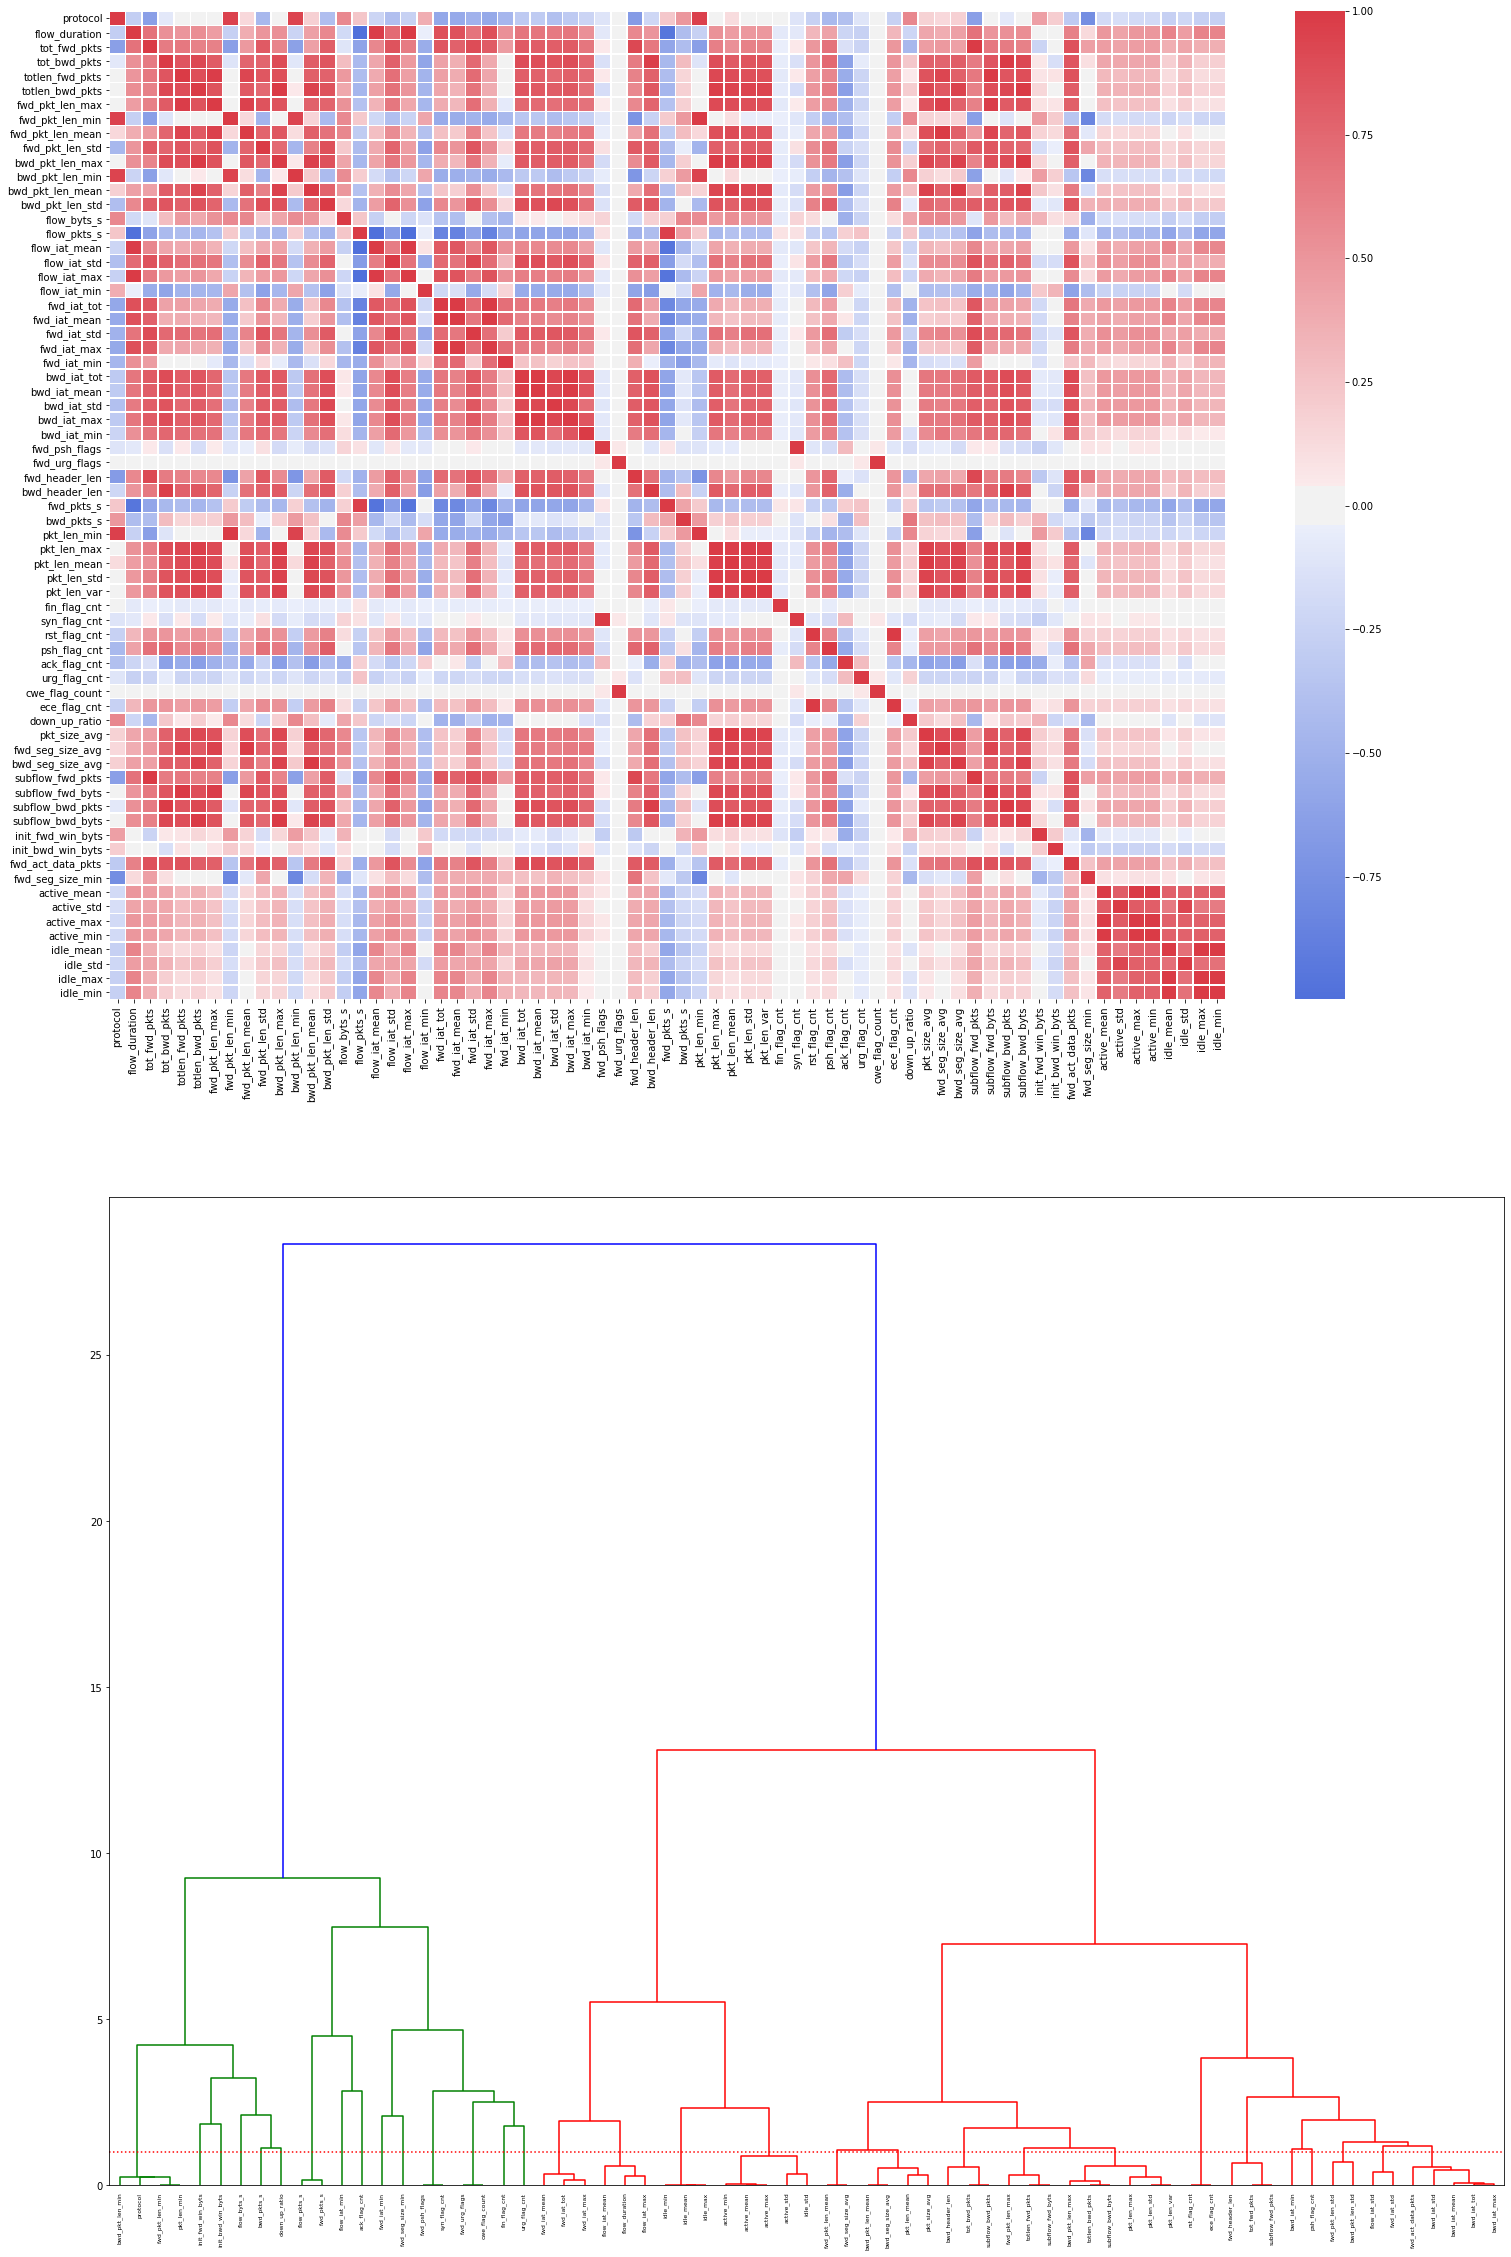

In [8]:
cluster_threshold = 1

corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 40))

sns.heatmap(corr, xticklabels=X.columns, yticklabels=X.columns, linewidths=.5, cmap=sns.diverging_palette(620, 10, as_cmap=True), ax=ax1)

dendro = hierarchy.dendrogram(corr_linkage, labels=X.columns, ax=ax2, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))
ax2.plot([0, 1000], [cluster_threshold, cluster_threshold], ':r')
plt.show()

In [9]:
cluster_ids = hierarchy.fcluster(corr_linkage, cluster_threshold, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)

for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

selected_features = X.columns[selected_features].tolist()

print('Selected features:')
pd.Series(selected_features)

Selected features:


0              protocol
1         flow_duration
2          tot_fwd_pkts
3          tot_bwd_pkts
4       totlen_fwd_pkts
5       totlen_bwd_pkts
6      fwd_pkt_len_mean
7       fwd_pkt_len_std
8      bwd_pkt_len_mean
9           flow_byts_s
10          flow_pkts_s
11         flow_iat_std
12         flow_iat_min
13          fwd_iat_tot
14          fwd_iat_min
15          bwd_iat_tot
16          bwd_iat_min
17        fwd_psh_flags
18        fwd_urg_flags
19           bwd_pkts_s
20         fin_flag_cnt
21         rst_flag_cnt
22         psh_flag_cnt
23         ack_flag_cnt
24         urg_flag_cnt
25        down_up_ratio
26    init_fwd_win_byts
27    init_bwd_win_byts
28     fwd_seg_size_min
29          active_mean
30            idle_mean
dtype: object

In [10]:
X = X[selected_features]
print(f"Remaining amount of features: {len(X.columns)}")

Remaining amount of features: 31


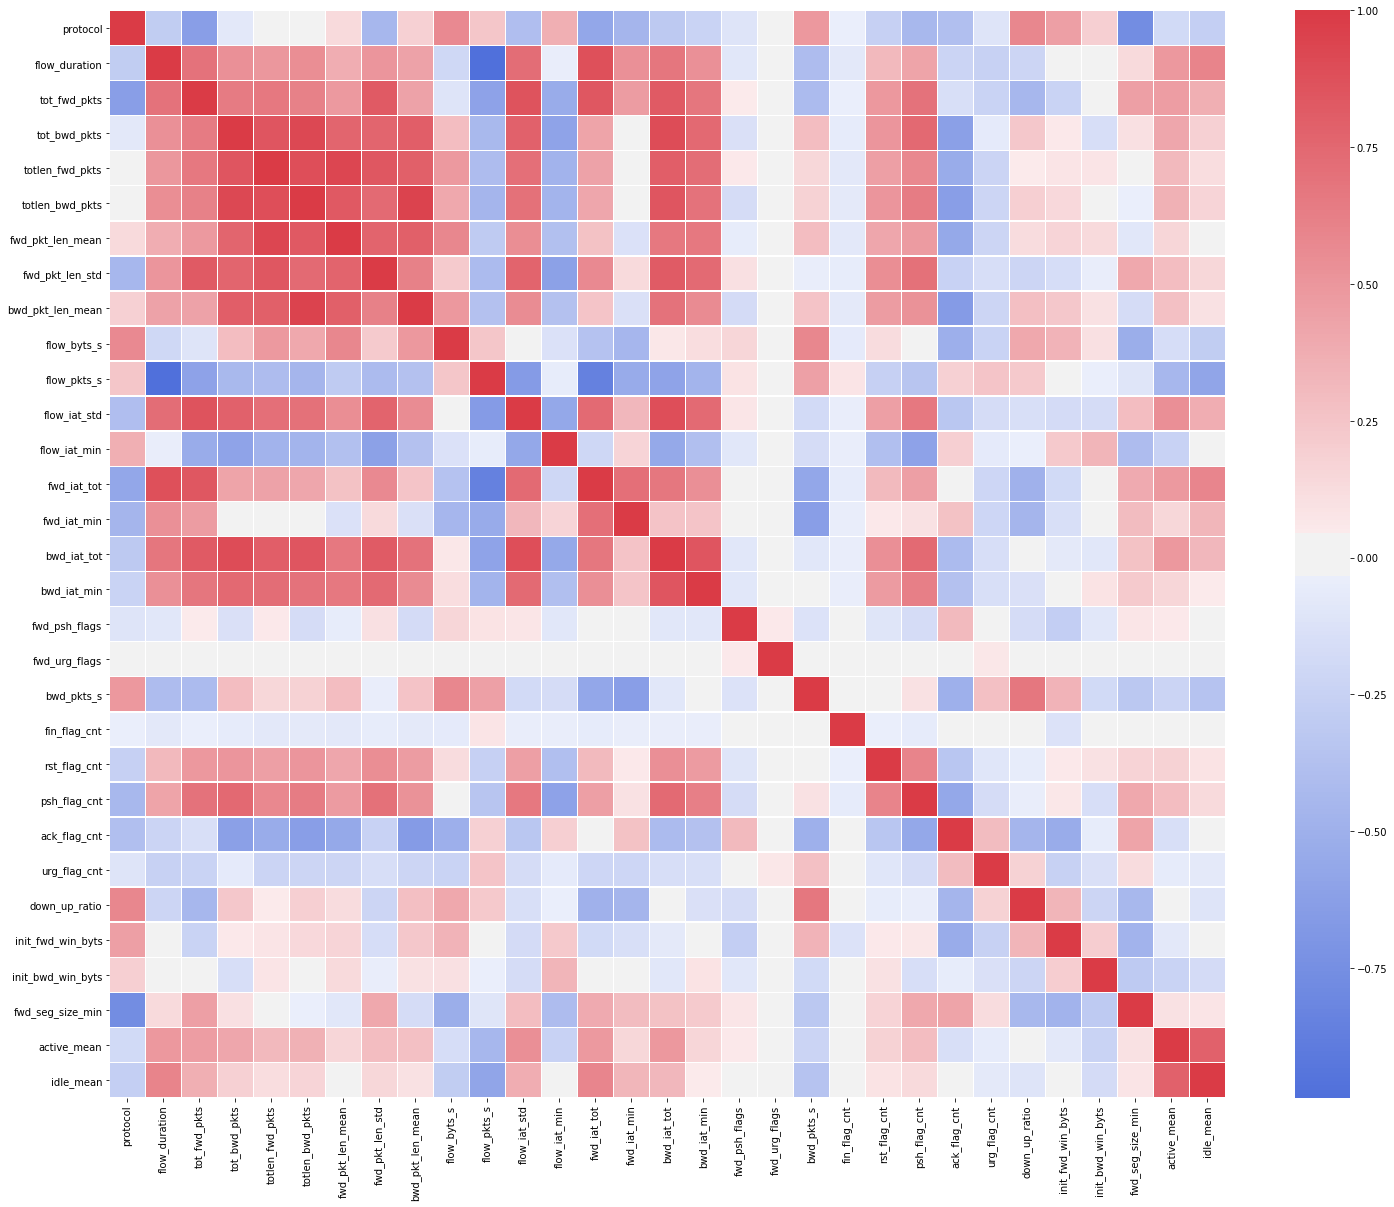

In [11]:
corr_updated = spearmanr(X).correlation
plt.figure(figsize=(25, 20))
sns.heatmap(corr_updated, xticklabels=X.columns, yticklabels=X.columns, linewidths=.5, cmap=sns.diverging_palette(620, 10, as_cmap=True))

## 3. Save fitur yang telah terpilih dalam 1 file

In [12]:
## join all dataset dengan fitur hasil seleksi
tmp_path = os.path.join(dataset_base_path, 'selected_features')

if not os.path.exists(tmp_path):
    os.mkdir(tmp_path)
    
tmp_file_path = os.path.join(tmp_path, 'selected_features.csv')

X.to_csv(tmp_file_path)

In [13]:
##cek sisa kolom tersisa yang ada pada file
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16232943 entries, 0 to 1048574
Data columns (total 31 columns):
 #   Column             Dtype  
---  ------             -----  
 0   protocol           uint8  
 1   flow_duration      float64
 2   tot_fwd_pkts       uint32 
 3   tot_bwd_pkts       uint32 
 4   totlen_fwd_pkts    uint32 
 5   totlen_bwd_pkts    uint32 
 6   fwd_pkt_len_mean   float32
 7   fwd_pkt_len_std    float32
 8   bwd_pkt_len_mean   float32
 9   flow_byts_s        float64
 10  flow_pkts_s        float64
 11  flow_iat_std       float32
 12  flow_iat_min       float64
 13  fwd_iat_tot        float64
 14  fwd_iat_min        float64
 15  bwd_iat_tot        uint32 
 16  bwd_iat_min        uint32 
 17  fwd_psh_flags      uint8  
 18  fwd_urg_flags      uint8  
 19  bwd_pkts_s         float32
 20  fin_flag_cnt       uint8  
 21  rst_flag_cnt       uint8  
 22  psh_flag_cnt       uint8  
 23  ack_flag_cnt       uint8  
 24  urg_flag_cnt       uint8  
 25  down_up_ratio    